<a href="https://colab.research.google.com/github/aanandmahawal/next-location-prediction-ml/blob/main/ML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📁 1. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📦 2. Unzip the Geolife Dataset

In [ ]:
import zipfile
import os

# Set path to the zip file in your Google Drive
zip_path = "/content/drive/MyDrive/ML_DATASET/Geolife Trajectories 1.3.zip"
extract_path = "/content/drive/MyDrive/ML_DATASET/Geolife Trajectories 1.3"

# Create directory if not exists
os.makedirs(extract_path, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed.")


✅ Extraction completed.


📑 3. Load and Prepare Data

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/ML_DATASET/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"

# Load .plt file
df = pd.read_csv(file_path, skiprows=6, header=None)
df.columns = ['lat', 'lon', '_', 'alt', 'days', 'date', 'time']

# Create timestamp and extract features
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df = df[['lat', 'lon', 'timestamp', 'hour', 'weekday']]


⚙️ 4. Feature Engineering

In [ ]:
import numpy as np

# Targets
df['target_lat'] = df['lat'].shift(-1)
df['target_lon'] = df['lon'].shift(-1)
df.dropna(inplace=True)

# Add noise
df['lat'] = df['lat'].round(3) + np.random.normal(0, 0.005, len(df))
df['lon'] = df['lon'].round(3) + np.random.normal(0, 0.005, len(df))

# Spatial features
df['dist_from_center'] = np.sqrt((df['lat'] - df['lat'].mean())**2 +
                                 (df['lon'] - df['lon'].mean())**2)
df['angle_from_center'] = np.arctan2(df['lat'] - df['lat'].mean(),
                                     df['lon'] - df['lon'].mean())

# Temporal features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


🎯 5. Prepare Features and Labels

In [ ]:
# Features and targets
X = df[['dist_from_center', 'angle_from_center', 'hour_sin', 'hour_cos', 'hour']]
y_lat = df['target_lat']
y_lon = df['target_lon']


🔀 6. Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_lat_train, y_lat_test = train_test_split(X, y_lat, test_size=0.2, random_state=42)
_, _, y_lon_train, y_lon_test = train_test_split(X, y_lon, test_size=0.2, random_state=42)


🌲 7. Random Forest with Grid Search & Cross-Validation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

param_grid = {
    'randomforestregressor__n_estimators': [10, 20],
    'randomforestregressor__max_depth': [2, 3],
    'randomforestregressor__min_samples_leaf': [20, 30],
    'randomforestregressor__max_features': [0.3, 0.5],
    'randomforestregressor__min_samples_split': [20, 30]
}

def create_pipeline():
    return make_pipeline(
        StandardScaler(),
        RandomForestRegressor(random_state=42)
    )

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate(target):
    pipeline = create_pipeline()
    grid = GridSearchCV(pipeline, param_grid, cv=cv,
                        scoring='neg_mean_squared_error', n_jobs=-1)

    y_train = y_lat_train if target == 'lat' else y_lon_train
    y_test = y_lat_test if target == 'lat' else y_lon_test

    grid.fit(X_train, y_train)

    cv_results = cross_validate(grid.best_estimator_, X_train, y_train,
                                cv=cv, scoring=('r2', 'neg_mean_squared_error'),
                                return_train_score=True)
    y_pred = grid.predict(X_test)

    print(f"\n=== {target.upper()} MODEL ===")
    print("✅ Best params:", grid.best_params_)
    print(f"📊 CV Train R²: {cv_results['train_r2'].mean():.4f}")
    print(f"📊 CV Test R²: {cv_results['test_r2'].mean():.4f}")
    print(f"📉 Test R²: {r2_score(y_test, y_pred):.4f}")
    print(f"📏 Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")

    model = grid.best_estimator_.named_steps['randomforestregressor']
    print("\n🔍 Feature Importances:")
    for name, importance in zip(X.columns, model.feature_importances_):
        print(f"{name}: {importance:.4f}")

    return grid, y_pred

print("🚀 Training models with reduced overfitting...")
grid_lat, y_lat_pred = train_and_evaluate('lat')
grid_lon, y_lon_pred = train_and_evaluate('lon')


🚀 Training models with reduced overfitting...

=== LAT MODEL ===
✅ Best params: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__min_samples_leaf': 30, 'randomforestregressor__min_samples_split': 20, 'randomforestregressor__n_estimators': 10}
📊 CV Train R²: 0.9616
📊 CV Test R²: 0.9582
📉 Test R²: 0.9631
📏 Test RMSE: 0.002015

🔍 Feature Importances:
dist_from_center: 0.0203
angle_from_center: 0.2958
hour_sin: 0.0481
hour_cos: 0.3740
hour: 0.2619

=== LON MODEL ===
✅ Best params: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__min_samples_leaf': 20, 'randomforestregressor__min_samples_split': 20, 'randomforestregressor__n_estimators': 20}
📊 CV Train R²: 0.8563
📊 CV Test R²: 0.8363
📉 Test R²: 0.8126
📏 Test RMSE: 0.003138

🔍 Feature Importances:
dist_from_center: 0.1653
angle_from_center: 0.5795
hour_sin: 0.0168
hour_cos: 0.1168
hour: 0.1216


📊 8. Plot Actual vs Predicted (Latitude & Longitude)

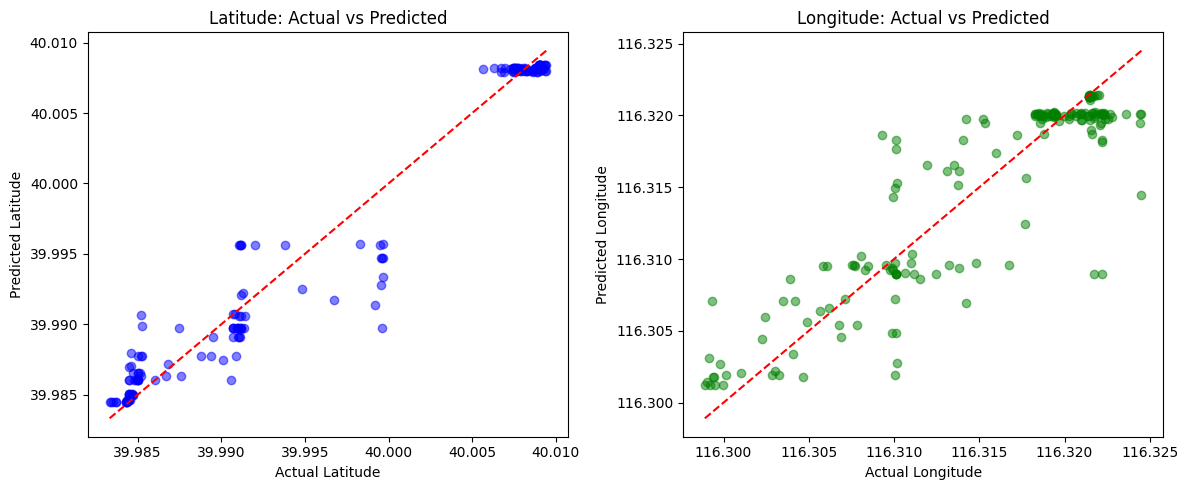

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_lat_test[:500], y_lat_pred[:500], alpha=0.5, color='blue')
plt.plot([y_lat_test.min(), y_lat_test.max()], [y_lat_test.min(), y_lat_test.max()], 'r--')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Latitude: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_lon_test[:500], y_lon_pred[:500], alpha=0.5, color='green')
plt.plot([y_lon_test.min(), y_lon_test.max()], [y_lon_test.min(), y_lon_test.max()], 'r--')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Longitude: Actual vs Predicted')

plt.tight_layout()
plt.show()


🔮 9. Predict Next Location from Custom Input

In [ ]:
# 🔮 Custom input prediction (with delta approach)

def prepare_input(lat, lon, hour):
    return pd.DataFrame([{
        'dist_from_center': np.sqrt((lat - df['lat'].mean())**2 + (lon - df['lon'].mean())**2),
        'angle_from_center': np.arctan2(lat - df['lat'].mean(), lon - df['lon'].mean()),
        'hour_sin': np.sin(2 * np.pi * hour / 24),
        'hour_cos': np.cos(2 * np.pi * hour / 24),
        'hour': hour
    }])


# 🧪 Try custom input
current_lat = 39.9847
current_lon = 116.3184
current_hour = 14

custom_input = prepare_input(current_lat, current_lon, current_hour)

# Predict delta
delta_lat = grid_lat.predict(custom_input)[0]
delta_lon = grid_lon.predict(custom_input)[0]

# Add to current location
pred_lat = current_lat + delta_lat
pred_lon = current_lon + delta_lon

print(f"🧭 Current Location: Latitude={current_lat}, Longitude={current_lon}")
print(f"📍 Predicted Next Location: Latitude={pred_lat:.6f}, Longitude={pred_lon:.6f}")



🧭 Current Location: Latitude=39.9847, Longitude=116.3184
📍 Predicted Next Location: Latitude=79.986073, Longitude=232.638090
